SST2 Training Data Shape: (6919, 2)
SST2 Test Data Shape: (1820, 2)
IMDB Data Shape: (50000, 2)

SST2 Training Data Preview:
  a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films  \
0  apparently reassembled from the cutting room f...                                                        
1  they presume their audience wo n't sit still f...                                                        
2  this is a visually stunning rumination on love...                                                        
3  jonathan parker 's bartleby should have been t...                                                        
4  campanella gets the tone just right funny in t...                                                        

   1  
0  0  
1  0  
2  1  
3  1  
4  1  

SST2 Test Data Preview:
        no movement , no yuks , not much of anything  0
0  a gob of drivel so sickly sweet , even the eag...  0
1  gangs of new york is an unapologetic m

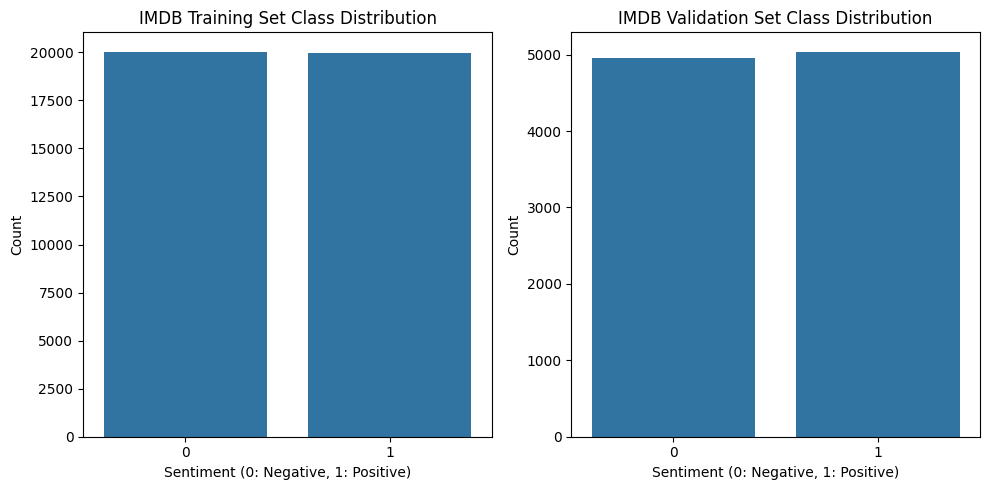


Datasets have been prepared and saved to CSV files.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Load Dataset 1: SST2
# Training data
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
train_data = pd.read_csv(train_url, sep='\t')

# Test data
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
test_data = pd.read_csv(test_url, sep='\t')

# Load Dataset 2: IMDB
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_data = pd.read_csv(imdb_url)

# Display basic information about the datasets
print("SST2 Training Data Shape:", train_data.shape)
print("SST2 Test Data Shape:", test_data.shape)
print("IMDB Data Shape:", imdb_data.shape)

# Display the first few rows of each dataset
print("\nSST2 Training Data Preview:")
print(train_data.head())

print("\nSST2 Test Data Preview:")
print(test_data.head())

print("\nIMDB Data Preview:")
print(imdb_data.head())

# Check for missing values
print("\nMissing values in SST2 Training Data:", train_data.isnull().sum().sum())
print("Missing values in SST2 Test Data:", test_data.isnull().sum().sum())
print("Missing values in IMDB Data:", imdb_data.isnull().sum().sum())

# Split SST2 training data into training and validation sets (80/20 split)
train_data_final, val_data = train_test_split(
    train_data,
    test_size=0.2,
    random_state=42
)

print("\nAfter splitting:")
print("SST2 Final Training Data Shape:", train_data_final.shape)
print("SST2 Validation Data Shape:", val_data.shape)


# For IMDB dataset, transform the sentiment labels to match SST2 format (0 and 1)
if 'sentiment' in imdb_data.columns:
    # Map 'positive' to 1 and 'negative' to 0
    imdb_data['label'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})

    # Split IMDB data into training and validation sets (80/20 split)
    imdb_train, imdb_val = train_test_split(
        imdb_data,
        test_size=0.2,
        random_state=42
    )

    print("\nIMDB Training Data Shape:", imdb_train.shape)
    print("IMDB Validation Data Shape:", imdb_val.shape)

    # Visualize IMDB class distribution
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x='label', data=imdb_train)
    plt.title('IMDB Training Set Class Distribution')
    plt.xlabel('Sentiment (0: Negative, 1: Positive)')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.countplot(x='label', data=imdb_val)
    plt.title('IMDB Validation Set Class Distribution')
    plt.xlabel('Sentiment (0: Negative, 1: Positive)')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig('imdb_class_distribution.png')
    plt.show()

# Save the prepared datasets for future use
train_data_final.to_csv('sst2_train.csv', index=False)
val_data.to_csv('sst2_val.csv', index=False)
test_data.to_csv('sst2_test.csv', index=False)

if 'label' in imdb_data.columns:
    imdb_train.to_csv('imdb_train.csv', index=False)
    imdb_val.to_csv('imdb_val.csv', index=False)

print("\nDatasets have been prepared and saved to CSV files.")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class SentimentMLP(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(SentimentMLP, self).__init__()

        # Input layer to first hidden layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        # First hidden layer to second hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        # Second hidden layer to third hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        # Third hidden layer to fourth hidden layer
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        # Fourth hidden layer to output layer
        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Input layer to first hidden layer with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # First hidden layer to second hidden layer with ReLU and dropout
        x = self.dropout(F.relu(self.fc2(x)))
        # Second hidden layer to third hidden layer with ReLU and dropout
        x = self.dropout(F.relu(self.fc3(x)))
        # Third hidden layer to fourth hidden layer with ReLU and dropout
        x = self.dropout(F.relu(self.fc4(x)))
        # Fourth hidden layer to output layer
        x = self.fc5(x)

        return x

# Initialize the model
model = SentimentMLP(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2)

# Function to count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model architecture and parameter count
def print_model_summary(model):
    print("Model Summary:")
    print("=" * 60)
    print(f"Input Size: {10000}")

    # Layer 1
    print(f"Layer 1: Linear(10000, 512)")
    print(f"    Parameters: {10000 * 512 + 512:,}")
    print(f"    Activation: ReLU + Dropout(0.3)")

    # Layer 2
    print(f"Layer 2: Linear(512, 256)")
    print(f"    Parameters: {512 * 256 + 256:,}")
    print(f"    Activation: ReLU + Dropout(0.3)")

    # Layer 3
    print(f"Layer 3: Linear(256, 128)")
    print(f"    Parameters: {256 * 128 + 128:,}")
    print(f"    Activation: ReLU + Dropout(0.3)")

    # Layer 4
    print(f"Layer 4: Linear(128, 64)")
    print(f"    Parameters: {128 * 64 + 64:,}")
    print(f"    Activation: ReLU + Dropout(0.3)")

    # Layer 5
    print(f"Layer 5: Linear(64, 2)")
    print(f"    Parameters: {64 * 2 + 2:,}")

    # Total parameters
    total_params = count_parameters(model)
    print("=" * 60)
    print(f"Total Trainable Parameters: {total_params:,}")

# Print the model summary
print_model_summary(model)

# Print the PyTorch model to verify its structure
print("\nPyTorch Model Structure:")
print(model)

# Verify parameter count using PyTorch's built-in function
print(f"\nTotal trainable parameters (using PyTorch's function): {count_parameters(model):,}")

Model Summary:
Input Size: 10000
Layer 1: Linear(10000, 512)
    Parameters: 5,120,512
    Activation: ReLU + Dropout(0.3)
Layer 2: Linear(512, 256)
    Parameters: 131,328
    Activation: ReLU + Dropout(0.3)
Layer 3: Linear(256, 128)
    Parameters: 32,896
    Activation: ReLU + Dropout(0.3)
Layer 4: Linear(128, 64)
    Parameters: 8,256
    Activation: ReLU + Dropout(0.3)
Layer 5: Linear(64, 2)
    Parameters: 130
Total Trainable Parameters: 5,293,122

PyTorch Model Structure:
SentimentMLP(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total trainable parameters (using PyTorch's function): 5,293,122


Training set shape: (5536, 2)
Validation set shape: (1385, 2)
Test set shape: (1821, 2)
Training features shape: (5536, 10000)
Validation features shape: (1385, 10000)
Test features shape: (1821, 10000)
Vocabulary size: 10000
Sample of vocabulary (first 20 words): ['10' '100' '101' '11' '112' '12' '120' '127' '129' '13' '14' '140' '146'
 '15' '15th' '16' '163' '170' '1790' '18']
Number of batches in training set: 87
Number of batches in validation set: 22
Number of batches in test set: 29
Batch features shape: torch.Size([64, 10000])
Batch labels shape: torch.Size([64])
Sum of first sample features: 18.0
Label counts in batch: tensor([31, 33])
Total trainable parameters in BoW model: 5,293,122
BoW representation sparsity: 0.0015
Average words per document: 15.91


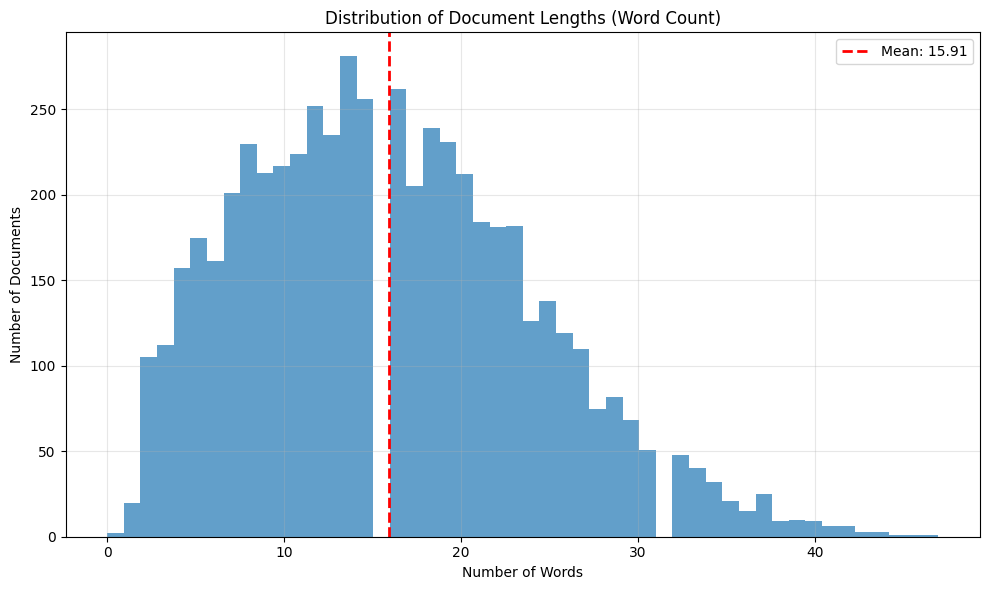

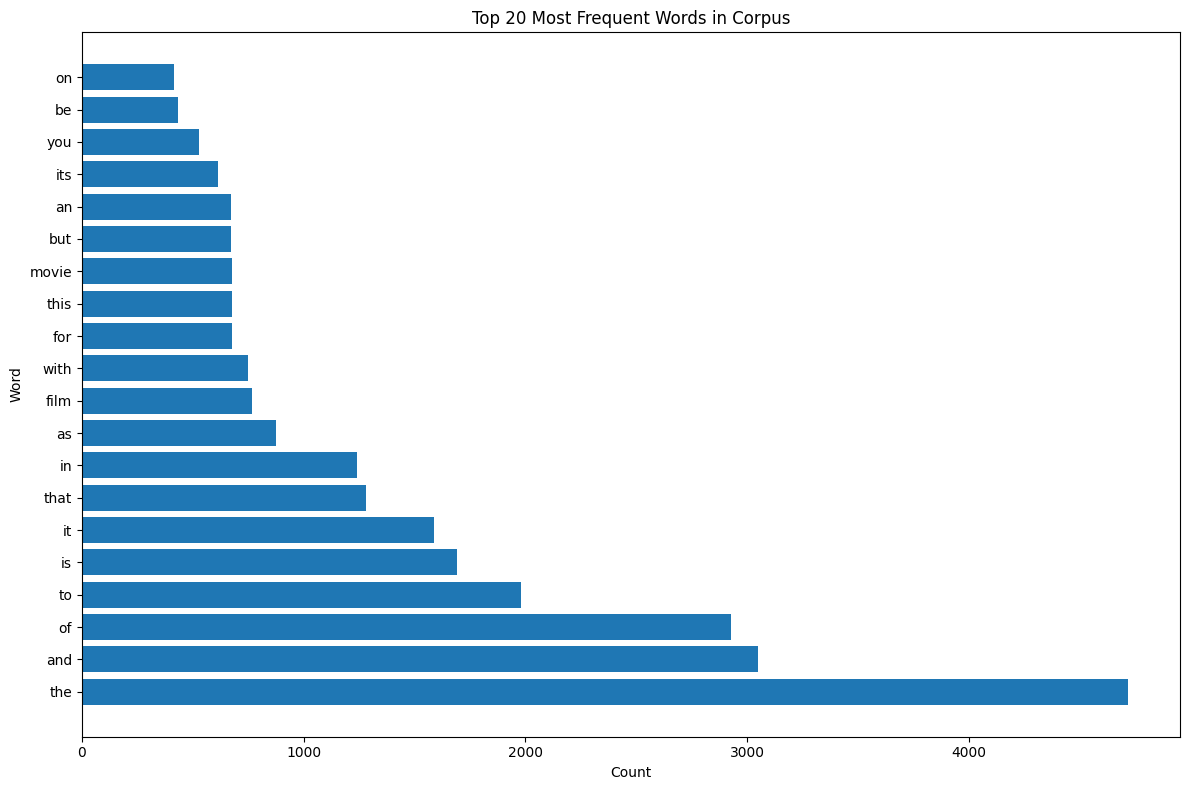

Bag-of-Words implementation completed successfully.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the datasets created in Task 1
# Load the datasets created in Task 1, specifying the column names
train_data = pd.read_csv('sst2_train.csv', names=['sentence', 'label'])
val_data = pd.read_csv('sst2_val.csv', names=['sentence', 'label'])
test_data = pd.read_csv('sst2_test.csv', names=['sentence', 'label'])

# Print dataset shapes
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Initialize the CountVectorizer with max_features=10000
vectorizer = CountVectorizer(max_features=10000)

# Fit the vectorizer on the training data
X_train_bow = vectorizer.fit_transform(train_data['sentence'])
X_val_bow = vectorizer.transform(val_data['sentence'])
X_test_bow = vectorizer.transform(test_data['sentence'])

# Convert labels to numpy arrays
y_train = train_data['label'].values
y_val = val_data['label'].values
y_test = test_data['label'].values

# Print the shapes of the feature matrices
print(f"Training features shape: {X_train_bow.shape}")
print(f"Validation features shape: {X_val_bow.shape}")
print(f"Test features shape: {X_test_bow.shape}")

# Display the vocabulary size
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# Show the most common words in the vocabulary
feature_names = vectorizer.get_feature_names_out()
print("Sample of vocabulary (first 20 words):", feature_names[:20])

# Create a PyTorch Dataset class for BoW features
class BowDataset(Dataset):
    def __init__(self, X, y):
        # Convert sparse matrix to dense tensor
        self.X = torch.FloatTensor(X.toarray())
        self.y = torch.LongTensor(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64

train_dataset = BowDataset(X_train_bow, y_train)
val_dataset = BowDataset(X_val_bow, y_val)
test_dataset = BowDataset(X_test_bow, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

# Verify the data by looking at a batch
for batch_X, batch_y in train_loader:
    print(f"Batch features shape: {batch_X.shape}")
    print(f"Batch labels shape: {batch_y.shape}")
    # Print the sum of the first sample to check if it contains non-zero values
    print(f"Sum of first sample features: {batch_X[0].sum()}")
    # Print the distribution of labels in this batch
    print(f"Label counts in batch: {torch.bincount(batch_y)}")
    break

# Define the MLP model from Task 2
class SentimentMLP(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(SentimentMLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.dropout(torch.relu(self.fc4(x)))
        x = self.fc5(x)

        return x

# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize the BoW model
bow_model = SentimentMLP(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2)
print(f"Total trainable parameters in BoW model: {count_parameters(bow_model):,}")

# Visualize some statistics about the BoW representation
# Calculate the average number of non-zero features per document
sparsity = X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1])
print(f"BoW representation sparsity: {sparsity:.4f}")

# Calculate the average number of words per document
words_per_doc = X_train_bow.sum(axis=1).mean()
print(f"Average words per document: {words_per_doc:.2f}")

# Plot the distribution of document lengths
doc_lengths = X_train_bow.sum(axis=1).A1
plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=50, alpha=0.7)
plt.axvline(doc_lengths.mean(), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {doc_lengths.mean():.2f}')
plt.title('Distribution of Document Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bow_document_lengths.png')
plt.show()

# Find the most frequent words in the corpus
word_counts = X_train_bow.sum(axis=0).A1
top_indices = word_counts.argsort()[-20:][::-1]
top_words = [feature_names[i] for i in top_indices]
top_counts = [word_counts[i] for i in top_indices]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_words)), top_counts, align='center')
plt.yticks(range(len(top_words)), top_words)
plt.title('Top 20 Most Frequent Words in Corpus')
plt.xlabel('Count')
plt.ylabel('Word')
plt.tight_layout()
plt.savefig('bow_top_words.png')
plt.show()

print("Bag-of-Words implementation completed successfully.")

In [4]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0


Using device: cpu
Training set shape: (5536, 2)
Validation set shape: (1385, 2)
Test set shape: (1821, 2)
Loading tokenizer and model for bert-base-uncased...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded with embedding size: 768
Processing training data...


Processing chunks: 100%|██████████| 4/4 [00:28<00:00,  7.18s/it]


Processing validation data...


Processing chunks: 100%|██████████| 4/4 [00:26<00:00,  6.57s/it]


Processing test data...


Processing chunks: 100%|██████████| 4/4 [00:27<00:00,  6.83s/it]


Embeddings saved to disk.
Embedding size: 768
Total trainable parameters in embedding model: 566,338


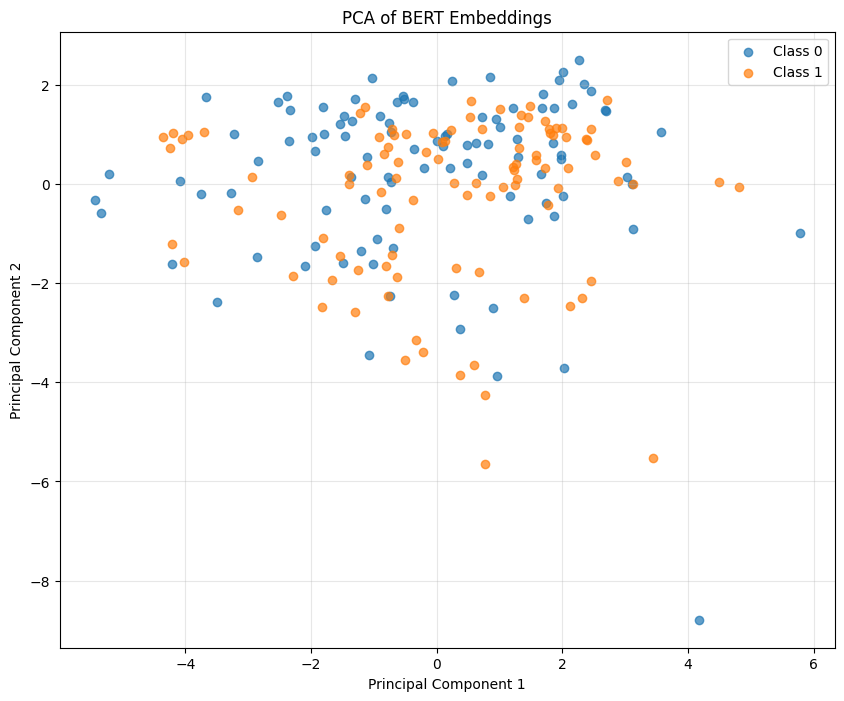

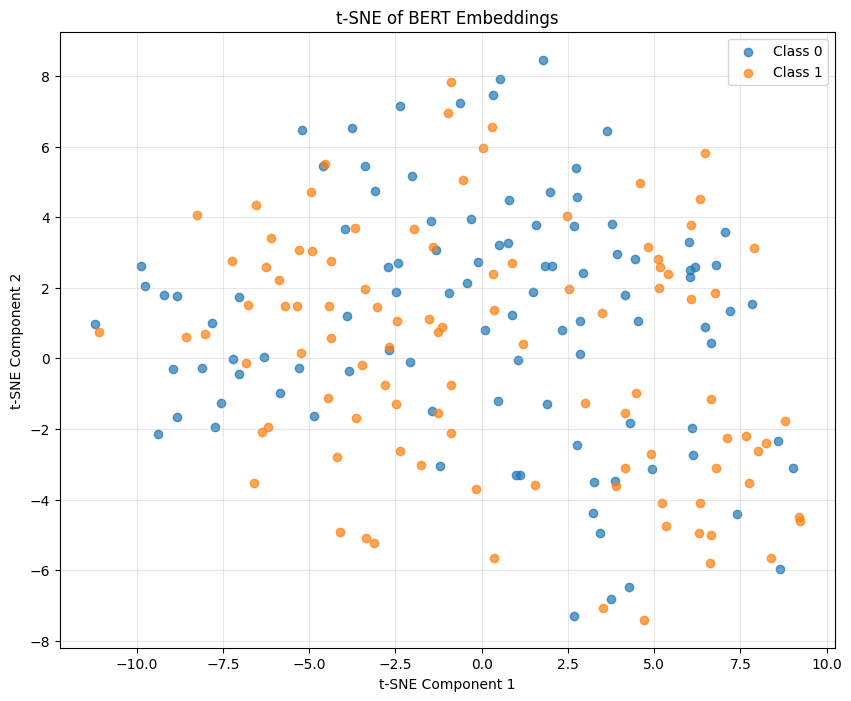

Extracting embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

Example embeddings shape: (3, 768)
Cosine similarity between example sentences:
Similarity between "I loved this movie, it was amazing!" and "This film was terrible and boring.": 0.8485
Similarity between "I loved this movie, it was amazing!" and "The plot was interesting but the acting was poor.": 0.7988
Similarity between "This film was terrible and boring." and "The plot was interesting but the acting was poor.": 0.8938
BERT embeddings implementation completed successfully.


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the datasets created in Task 1
# Assuming the CSV files have columns 'sentence' and 'label'
train_data = pd.read_csv('sst2_train.csv', names=['sentence', 'label'])  # Specify column names if not present in the CSV
val_data = pd.read_csv('sst2_val.csv', names=['sentence', 'label'])     # Specify column names if not present in the CSV
test_data = pd.read_csv('sst2_test.csv', names=['sentence', 'label'])    # Specify column names if not present in the CSV

# Print dataset shapes
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Define a class for the embedding extractor using BERT
class BertEmbeddingExtractor:
    def __init__(self, model_name="bert-base-uncased", max_length=128):
        self.model_name = model_name
        self.max_length = max_length
        self.device = device

        # Load tokenizer and model
        print(f"Loading tokenizer and model for {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.embedding_size = self.model.config.hidden_size
        print(f"Model loaded with embedding size: {self.embedding_size}")
        self.model_loaded = True

    def extract_embeddings(self, texts, batch_size=16):
        """Extract embeddings for a list of texts"""
        # Create tokenized inputs
        all_embeddings = []

        # Process in batches to avoid memory issues
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize the batch
            encoded_inputs = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            ).to(self.device)

            # Get model output
            with torch.no_grad():
                outputs = self.model(**encoded_inputs)

            # Use CLS token embeddings (first token) as the sentence representation
            # This is a common approach for BERT
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(batch_embeddings)

            # Clear GPU memory after each batch
            if device.type == 'cuda':
                torch.cuda.empty_cache()

        # Concatenate all batches
        embeddings = np.vstack(all_embeddings)
        return embeddings

    def get_embedding_size(self):
        """Return the embedding size of the model"""
        return self.embedding_size

# Create an embedding extractor
embedding_extractor = BertEmbeddingExtractor(model_name="bert-base-uncased")

# Function to process datasets in smaller chunks to manage memory
def process_in_chunks(data, chunk_size=50, total_samples=200):
    """Process the dataset in chunks and return a subset of the embeddings"""
    texts = data['sentence'].tolist() # Convert to list of strings
    labels = data['label'].values

    # If total_samples is specified, limit the processing
    if total_samples and total_samples < len(texts):
        indices = np.random.choice(len(texts), total_samples, replace=False)
        texts = [texts[i] for i in indices] # Select elements using indices
        labels = labels[indices]

    all_embeddings = []
    all_labels = []

    for i in tqdm(range(0, len(texts), chunk_size), desc="Processing chunks"):
        chunk_texts = texts[i:i+chunk_size]
        chunk_labels = labels[i:i+chunk_size]

        # Extract embeddings for this chunk
        chunk_embeddings = embedding_extractor.extract_embeddings(chunk_texts)

        all_embeddings.append(chunk_embeddings)
        all_labels.append(chunk_labels)

    # Concatenate all chunks
    embeddings = np.vstack(all_embeddings)
    labels = np.concatenate(all_labels)

    return embeddings, labels

# Process datasets with a limited number of samples to manage memory constraints
print("Processing training data...")
X_train_emb, y_train_emb = process_in_chunks(train_data, chunk_size=50, total_samples=200)

print("Processing validation data...")
X_val_emb, y_val_emb = process_in_chunks(val_data, chunk_size=50, total_samples=200)

print("Processing test data...")
X_test_emb, y_test_emb = process_in_chunks(test_data, chunk_size=50, total_samples=200)

# Save the embeddings to disk to avoid recomputing
np.save('X_train_bert_emb.npy', X_train_emb)
np.save('y_train_bert_emb.npy', y_train_emb)
np.save('X_val_bert_emb.npy', X_val_emb)
np.save('y_val_bert_emb.npy', y_val_emb)
np.save('X_test_bert_emb.npy', X_test_emb)
np.save('y_test_bert_emb.npy', y_test_emb)

print("Embeddings saved to disk.")

# Create PyTorch dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Create dataloaders
batch_size = 32

train_dataset = EmbeddingDataset(X_train_emb, y_train_emb)
val_dataset = EmbeddingDataset(X_val_emb, y_val_emb)
test_dataset = EmbeddingDataset(X_test_emb, y_test_emb)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the MLP model using the embedding size
class EmbeddingMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(EmbeddingMLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.dropout(torch.relu(self.fc4(x)))
        x = self.fc5(x)

        return x

# Get embedding size from the extractor
embedding_size = embedding_extractor.get_embedding_size()
print(f"Embedding size: {embedding_size}")

# Initialize the embedding-based model
emb_model = EmbeddingMLP(input_size=embedding_size, hidden_sizes=[512, 256, 128, 64], output_size=2)
emb_model = emb_model.to(device)

# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters in embedding model: {count_parameters(emb_model):,}")

# Visualize some of the embeddings using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_emb)

# Create a scatter plot of the embeddings
plt.figure(figsize=(10, 8))
for label in np.unique(y_train_emb):
    idx = y_train_emb == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=f'Class {label}', alpha=0.7)

plt.title('PCA of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('bert_embeddings_pca.png')
plt.show()

# Apply t-SNE for better visualization of high-dimensional data
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_emb)

# Create a scatter plot of the t-SNE embeddings
plt.figure(figsize=(10, 8))
for label in np.unique(y_train_emb):
    idx = y_train_emb == label
    plt.scatter(X_train_tsne[idx, 0], X_train_tsne[idx, 1], label=f'Class {label}', alpha=0.7)

plt.title('t-SNE of BERT Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('bert_embeddings_tsne.png')
plt.show()

# Compare the embedding vectors for a few example sentences
example_sentences = [
    "I loved this movie, it was amazing!",
    "This film was terrible and boring.",
    "The plot was interesting but the acting was poor."
]

# Extract embeddings for these examples
example_embeddings = embedding_extractor.extract_embeddings(example_sentences)

# Print the shape of the embeddings
print(f"Example embeddings shape: {example_embeddings.shape}")

# Calculate cosine similarity between embeddings
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(example_embeddings)
print("Cosine similarity between example sentences:")
for i, sent1 in enumerate(example_sentences):
    for j, sent2 in enumerate(example_sentences):
        if i < j:
            print(f"Similarity between \"{sent1}\" and \"{sent2}\": {similarity_matrix[i, j]:.4f}")

print("BERT embeddings implementation completed successfully.")

In [6]:
# APPROACH 1: BAG OF WORDS
# -----------------------
# (From Task 3)
# 1. Extract BoW features
vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(train_data['sentence'])
X_val_bow = vectorizer.transform(val_data['sentence'])
X_test_bow = vectorizer.transform(test_data['sentence'])

# 2. Create BoW datasets and dataloaders
bow_train_dataset = BowDataset(X_train_bow, y_train)
bow_val_dataset = BowDataset(X_val_bow, y_val)
bow_test_dataset = BowDataset(X_test_bow, y_test)

bow_train_loader = DataLoader(bow_train_dataset, batch_size=64, shuffle=True)
bow_val_loader = DataLoader(bow_val_dataset, batch_size=64)
bow_test_loader = DataLoader(bow_test_dataset, batch_size=64)

# 3. Create BoW model
bow_model = SentimentMLP(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2)

# APPROACH 2: EMBEDDINGS
# ----------------------
# (From Task 4)
# 1. Extract BERT embeddings
embedding_extractor = BertEmbeddingExtractor(model_name="bert-base-uncased")
X_train_emb, y_train_emb = process_in_chunks(train_data, chunk_size=50, total_samples=200)
X_val_emb, y_val_emb = process_in_chunks(val_data, chunk_size=50, total_samples=200)
X_test_emb, y_test_emb = process_in_chunks(test_data, chunk_size=50, total_samples=200)

# 2. Create embedding datasets and dataloaders
emb_train_dataset = EmbeddingDataset(X_train_emb, y_train_emb)
emb_val_dataset = EmbeddingDataset(X_val_emb, y_val_emb)
emb_test_dataset = EmbeddingDataset(X_test_emb, y_test_emb)

emb_train_loader = DataLoader(emb_train_dataset, batch_size=32, shuffle=True)
emb_val_loader = DataLoader(emb_val_dataset, batch_size=32)
emb_test_loader = DataLoader(emb_test_dataset, batch_size=32)


Loading tokenizer and model for bert-base-uncased...
Model loaded with embedding size: 768


Processing chunks: 100%|██████████| 4/4 [00:28<00:00,  7.02s/it]


In [7]:
# Define the train_model function
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    """
    Trains a given PyTorch model using the provided data loaders.
    """

    # Check if model is on the correct device (GPU or CPU)
    model = model.to(device)  # Move model to the appropriate device

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # Since it's a binary classification task

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data and target to the appropriate device
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    return model, train_losses, val_losses, val_accuracies

# Define the evaluate_model function (used within train_model)
def evaluate_model(model, data_loader, criterion):
    """
    Evaluates the model on the given data loader.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for data, target in data_loader:
            # Move data and target to the appropriate device
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)  # Get predicted class labels
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

# Assuming 'optim' is imported:
import torch.optim as optim


In [8]:
import os  # Import os for creating directory

def process_in_chunks(data, chunk_size=50, total_samples=200, text_column='sentence'):
    """Process the dataset in chunks and return a subset of the embeddings

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset to process
    chunk_size : int
        Number of samples to process at once
    total_samples : int or None
        Total number of samples to process, or None to process all
    text_column : str
        Name of the column containing the text data
    """
    # Check if the specified text column exists
    if text_column not in data.columns:
        # Try to find an alternative text column
        possible_text_columns = ['sentence', 'review', 'text', 'content']
        for col in possible_text_columns:
            if col in data.columns:
                text_column = col
                print(f"Using '{text_column}' as the text column instead.")
                break
        else:
            raise ValueError(f"Could not find a suitable text column in the dataset. Available columns: {data.columns.tolist()}")

    texts = data[text_column].values

    # Convert all text elements to strings
    texts = [str(text) for text in texts]  # Add this line

    labels = data['label'].values

    # If total_samples is specified, limit the processing
    if total_samples and total_samples < len(texts):
        indices = np.random.choice(len(texts), total_samples, replace=False)
        texts = [texts[i] for i in indices] # Select elements using indices
        labels = labels[indices]

    all_embeddings = []
    all_labels = []

    for i in tqdm(range(0, len(texts), chunk_size), desc="Processing chunks"):
        chunk_texts = texts[i:i+chunk_size]
        chunk_labels = labels[i:i+chunk_size]

        # Extract embeddings for this chunk
        chunk_embeddings = embedding_extractor.extract_embeddings(chunk_texts)

        all_embeddings.append(chunk_embeddings)
        all_labels.append(chunk_labels)

    # Concatenate all chunks
    embeddings = np.vstack(all_embeddings)
    labels = np.concatenate(all_labels)

    return embeddings, labels

Using device: cpu

TRAINING BAG-OF-WORDS MODEL ON SST2 DATASET


Epoch 1/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 20.01it/s]


Epoch 1/10
Train Loss: 0.6059, Val Loss: 0.4862, Val Acc: 0.7726
Checkpoint saved at checkpoints/bow_sst2_best.pt with val_acc: 0.7726


Epoch 2/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 18.29it/s]


Epoch 2/10
Train Loss: 0.2682, Val Loss: 0.4760, Val Acc: 0.7863
Checkpoint saved at checkpoints/bow_sst2_best.pt with val_acc: 0.7863


Epoch 3/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 18.33it/s]


Epoch 3/10
Train Loss: 0.0652, Val Loss: 0.9570, Val Acc: 0.7834


Epoch 4/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 19.95it/s]


Epoch 4/10
Train Loss: 0.0145, Val Loss: 1.2627, Val Acc: 0.7733


Epoch 5/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 19.97it/s]


Epoch 5/10
Train Loss: 0.0035, Val Loss: 1.7603, Val Acc: 0.7653


Epoch 6/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 21.93it/s]


Epoch 6/10
Train Loss: 0.0023, Val Loss: 1.8864, Val Acc: 0.7682


Epoch 7/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 19.99it/s]


Epoch 7/10
Train Loss: 0.0112, Val Loss: 1.1914, Val Acc: 0.7740


Epoch 8/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 18.28it/s]


Epoch 8/10
Train Loss: 0.0067, Val Loss: 1.4248, Val Acc: 0.7661


Epoch 9/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 18.37it/s]


Epoch 9/10
Train Loss: 0.0036, Val Loss: 1.7490, Val Acc: 0.7617


Epoch 10/10 [Val]: 100%|██████████| 22/22 [00:01<00:00, 18.33it/s]


Epoch 10/10
Train Loss: 0.0069, Val Loss: 1.5738, Val Acc: 0.7574
Final model saved at checkpoints/bow_sst2_final.pt


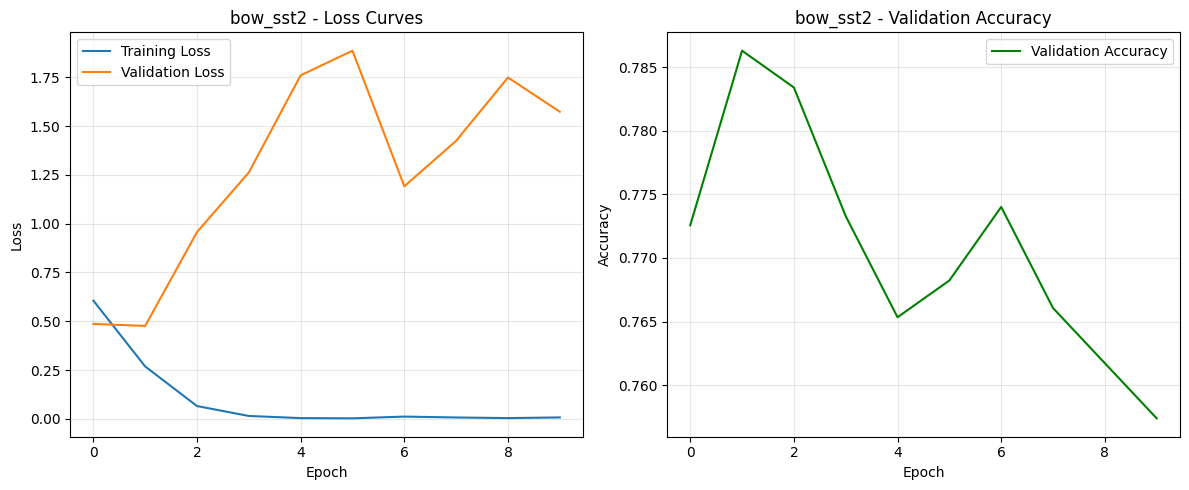

Evaluating: 100%|██████████| 29/29 [00:01<00:00, 20.57it/s]



BoW Model Test Loss: 1.5643, Test Accuracy: 0.7628

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.67      0.74       912
    Positive       0.72      0.85      0.78       909

    accuracy                           0.76      1821
   macro avg       0.77      0.76      0.76      1821
weighted avg       0.77      0.76      0.76      1821



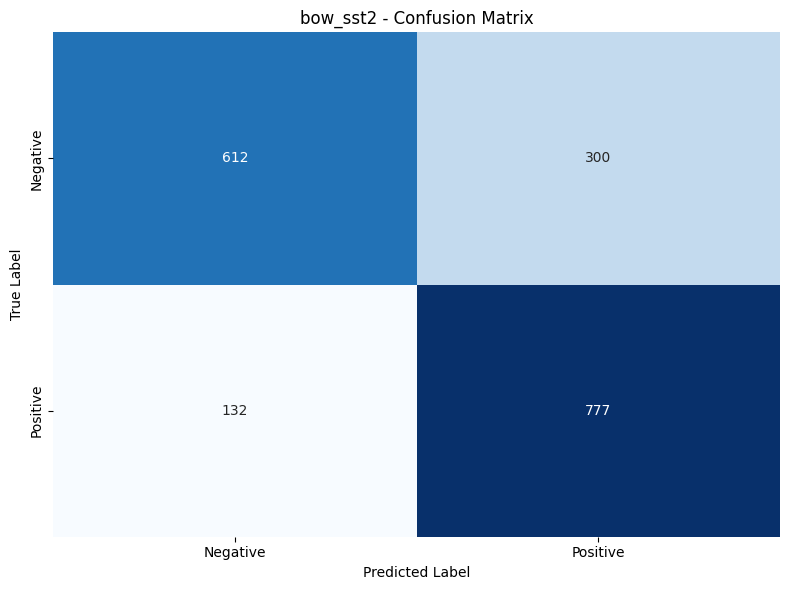


TRAINING BERT EMBEDDINGS MODEL ON SST2 DATASET


Epoch 1/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 67.30it/s]


Epoch 1/10
Train Loss: 0.6943, Val Loss: 0.6839, Val Acc: 0.5750
Checkpoint saved at checkpoints/bert_emb_sst2_best.pt with val_acc: 0.5750


Epoch 2/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.85it/s]


Epoch 2/10
Train Loss: 0.6871, Val Loss: 0.6694, Val Acc: 0.5750


Epoch 3/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.50it/s]


Epoch 3/10
Train Loss: 0.6716, Val Loss: 0.6358, Val Acc: 0.6650
Checkpoint saved at checkpoints/bert_emb_sst2_best.pt with val_acc: 0.6650


Epoch 4/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 66.80it/s]


Epoch 4/10
Train Loss: 0.6446, Val Loss: 0.5786, Val Acc: 0.6500


Epoch 5/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 23.55it/s]


Epoch 5/10
Train Loss: 0.5462, Val Loss: 0.4510, Val Acc: 0.7950
Checkpoint saved at checkpoints/bert_emb_sst2_best.pt with val_acc: 0.7950


Epoch 6/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.50it/s]


Epoch 6/10
Train Loss: 0.4173, Val Loss: 0.3813, Val Acc: 0.8400
Checkpoint saved at checkpoints/bert_emb_sst2_best.pt with val_acc: 0.8400


Epoch 7/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.57it/s]


Epoch 7/10
Train Loss: 0.4317, Val Loss: 0.5528, Val Acc: 0.7350


Epoch 8/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.32it/s]


Epoch 8/10
Train Loss: 0.4143, Val Loss: 0.3608, Val Acc: 0.8600
Checkpoint saved at checkpoints/bert_emb_sst2_best.pt with val_acc: 0.8600


Epoch 9/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.02it/s]


Epoch 9/10
Train Loss: 0.3326, Val Loss: 0.3649, Val Acc: 0.8450


Epoch 10/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.45it/s]


Epoch 10/10
Train Loss: 0.2213, Val Loss: 0.3504, Val Acc: 0.8550
Final model saved at checkpoints/bert_emb_sst2_final.pt


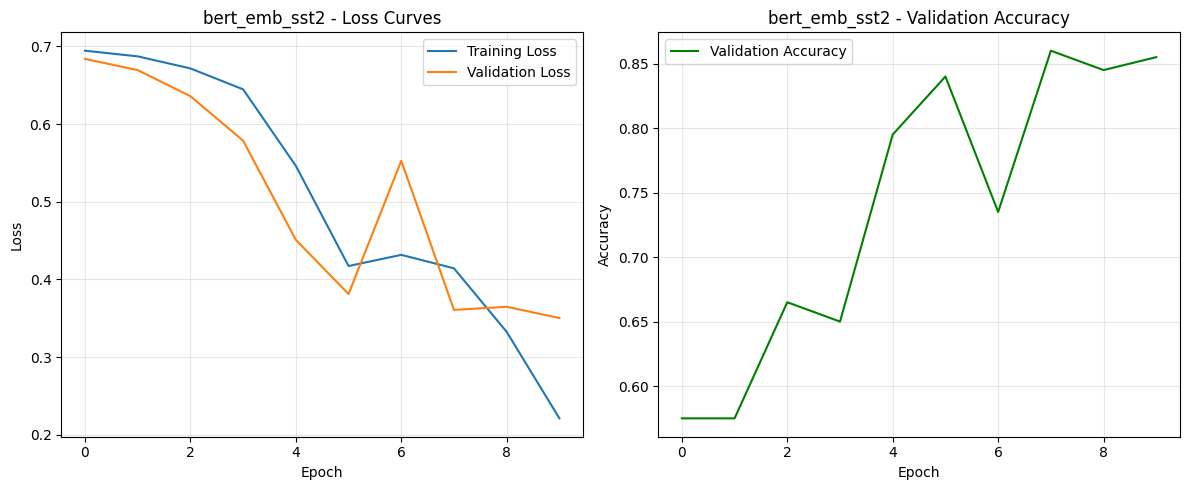

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 225.11it/s]



BERT Embeddings Model Test Loss: 0.3649, Test Accuracy: 0.8650

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87       101
    Positive       0.86      0.87      0.86        99

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200



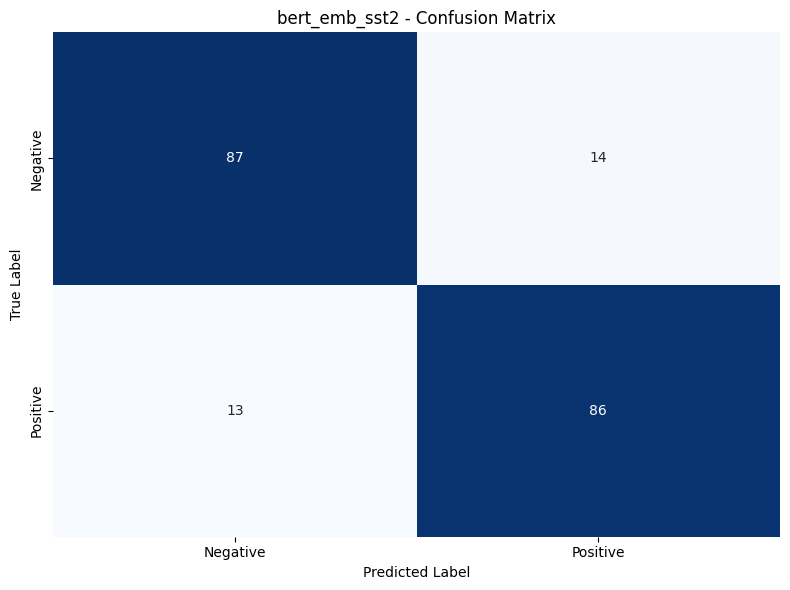


COMPARING MODELS ON SST2 DATASET
BoW Model Best Validation Accuracy: 0.7863
BoW Model Test Accuracy: 0.7628
BERT Embeddings Model Best Validation Accuracy: 0.8600
BERT Embeddings Model Test Accuracy: 0.8650


In [9]:


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Define a function to train the model and create checkpoint
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10,
                model_name="model", checkpoint_dir="checkpoints"):

    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Best validation accuracy to track improvement
    best_val_acc = 0.0

    # Move model to device
    model = model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        running_loss = 0.0

        # Train on batches
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            # Move tensors to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

        # Calculate average training loss for this epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Update validation loss
                val_loss += loss.item() * inputs.size(0)

                # Get predictions
                _, preds = torch.max(outputs, 1)

                # Store predictions and labels for metrics
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss and accuracy
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        epoch_val_acc = accuracy_score(all_labels, all_preds)
        val_accuracies.append(epoch_val_acc)

        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Save checkpoint if validation accuracy improved
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_best.pt")

            # Save model state, optimizer state, and other info
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
                'train_loss': epoch_train_loss,
            }, checkpoint_path)

            print(f"Checkpoint saved at {checkpoint_path} with val_acc: {epoch_val_acc:.4f}")

    # Save final model checkpoint
    final_checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_final.pt")
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_losses[-1],
        'val_acc': val_accuracies[-1],
        'train_loss': train_losses[-1],
    }, final_checkpoint_path)

    print(f"Final model saved at {final_checkpoint_path}")

    # Return model and metrics
    return model, train_losses, val_losses, val_accuracies, best_val_acc

# Function to visualize training metrics
def plot_training_curves(train_losses, val_losses, val_accuracies, model_name="model"):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png')
    plt.show()

# Function to evaluate model on test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])

    return avg_test_loss, test_accuracy, cm, report, all_preds, all_labels

# Function to visualize confusion matrix
def plot_confusion_matrix(cm, model_name="model"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

# TASK 5: Train models on Dataset 1 (SST2) and create checkpoints
# --------------------------------------------------------------

# 1. Train BoW Model
print("\n" + "="*50)
print("TRAINING BAG-OF-WORDS MODEL ON SST2 DATASET")
print("="*50)

# Initialize model, criterion, and optimizer
bow_model = SentimentMLP(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=0.001)

# Train and save checkpoint
bow_trained_model, bow_train_losses, bow_val_losses, bow_val_accuracies, bow_best_val_acc = train_model(
    bow_model,
    bow_train_loader,
    bow_val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    model_name="bow_sst2"
)

# Plot training curves
plot_training_curves(bow_train_losses, bow_val_losses, bow_val_accuracies, model_name="bow_sst2")

# Evaluate on test set
bow_test_loss, bow_test_acc, bow_cm, bow_report, bow_preds, bow_labels = evaluate_model(
    bow_trained_model, bow_test_loader, criterion
)

print(f"\nBoW Model Test Loss: {bow_test_loss:.4f}, Test Accuracy: {bow_test_acc:.4f}")
print("\nClassification Report:")
print(bow_report)

# Plot confusion matrix
plot_confusion_matrix(bow_cm, model_name="bow_sst2")

# 2. Train BERT Embeddings Model
print("\n" + "="*50)
print("TRAINING BERT EMBEDDINGS MODEL ON SST2 DATASET")
print("="*50)

# Initialize model, criterion, and optimizer
emb_model = EmbeddingMLP(input_size=embedding_size, hidden_sizes=[512, 256, 128, 64], output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb_model.parameters(), lr=0.001)

# Train and save checkpoint
emb_trained_model, emb_train_losses, emb_val_losses, emb_val_accuracies, emb_best_val_acc = train_model(
    emb_model,
    emb_train_loader,
    emb_val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    model_name="bert_emb_sst2"
)

# Plot training curves
plot_training_curves(emb_train_losses, emb_val_losses, emb_val_accuracies, model_name="bert_emb_sst2")

# Evaluate on test set
emb_test_loss, emb_test_acc, emb_cm, emb_report, emb_preds, emb_labels = evaluate_model(
    emb_trained_model, emb_test_loader, criterion
)

print(f"\nBERT Embeddings Model Test Loss: {emb_test_loss:.4f}, Test Accuracy: {emb_test_acc:.4f}")
print("\nClassification Report:")
print(emb_report)

# Plot confusion matrix
plot_confusion_matrix(emb_cm, model_name="bert_emb_sst2")

# Compare the two models on SST2
print("\n" + "="*50)
print("COMPARING MODELS ON SST2 DATASET")
print("="*50)
print(f"BoW Model Best Validation Accuracy: {bow_best_val_acc:.4f}")
print(f"BoW Model Test Accuracy: {bow_test_acc:.4f}")
print(f"BERT Embeddings Model Best Validation Accuracy: {emb_best_val_acc:.4f}")
print(f"BERT Embeddings Model Test Accuracy: {emb_test_acc:.4f}")


Processing IMDB training data for embeddings...


Processing chunks: 100%|██████████| 4/4 [00:56<00:00, 14.17s/it]


Processing IMDB validation data for embeddings...


Processing chunks: 100%|██████████| 4/4 [00:54<00:00, 13.52s/it]



CONTINUING TRAINING OF BAG-OF-WORDS MODEL ON IMDB DATASET
Loaded BoW model checkpoint from checkpoints/bow_sst2_best.pt
Checkpoint info - Epoch: 1, Val Acc: 0.7863


Epoch 1/10 [Val]: 100%|██████████| 157/157 [00:08<00:00, 19.39it/s]


Epoch 1/10
Train Loss: 0.4386, Val Loss: 0.3153, Val Acc: 0.8669
Checkpoint saved at checkpoints/bow_imdb_best.pt with val_acc: 0.8669


Epoch 2/10 [Val]: 100%|██████████| 157/157 [00:07<00:00, 20.12it/s]


Epoch 2/10
Train Loss: 0.2822, Val Loss: 0.2893, Val Acc: 0.8819
Checkpoint saved at checkpoints/bow_imdb_best.pt with val_acc: 0.8819


Epoch 3/10 [Val]: 100%|██████████| 157/157 [00:08<00:00, 18.26it/s]


Epoch 3/10
Train Loss: 0.2083, Val Loss: 0.2717, Val Acc: 0.8936
Checkpoint saved at checkpoints/bow_imdb_best.pt with val_acc: 0.8936


Epoch 4/10 [Val]: 100%|██████████| 157/157 [00:07<00:00, 19.88it/s]


Epoch 4/10
Train Loss: 0.1374, Val Loss: 0.3129, Val Acc: 0.8904


Epoch 5/10 [Val]: 100%|██████████| 157/157 [00:07<00:00, 20.15it/s]


Epoch 5/10
Train Loss: 0.0768, Val Loss: 0.3911, Val Acc: 0.8887


Epoch 6/10 [Val]: 100%|██████████| 157/157 [00:07<00:00, 20.67it/s]


Epoch 6/10
Train Loss: 0.0395, Val Loss: 0.5138, Val Acc: 0.8892


Epoch 7/10 [Val]: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s]


Epoch 7/10
Train Loss: 0.0266, Val Loss: 0.5463, Val Acc: 0.8870


Epoch 8/10 [Val]: 100%|██████████| 157/157 [00:08<00:00, 18.92it/s]


Epoch 8/10
Train Loss: 0.0166, Val Loss: 0.6765, Val Acc: 0.8870


Epoch 9/10 [Val]: 100%|██████████| 157/157 [00:08<00:00, 19.15it/s]


Epoch 9/10
Train Loss: 0.0141, Val Loss: 0.6479, Val Acc: 0.8877


Epoch 10/10 [Val]: 100%|██████████| 157/157 [00:08<00:00, 18.47it/s]


Epoch 10/10
Train Loss: 0.0100, Val Loss: 0.7823, Val Acc: 0.8733
Final model saved at checkpoints/bow_imdb_final.pt


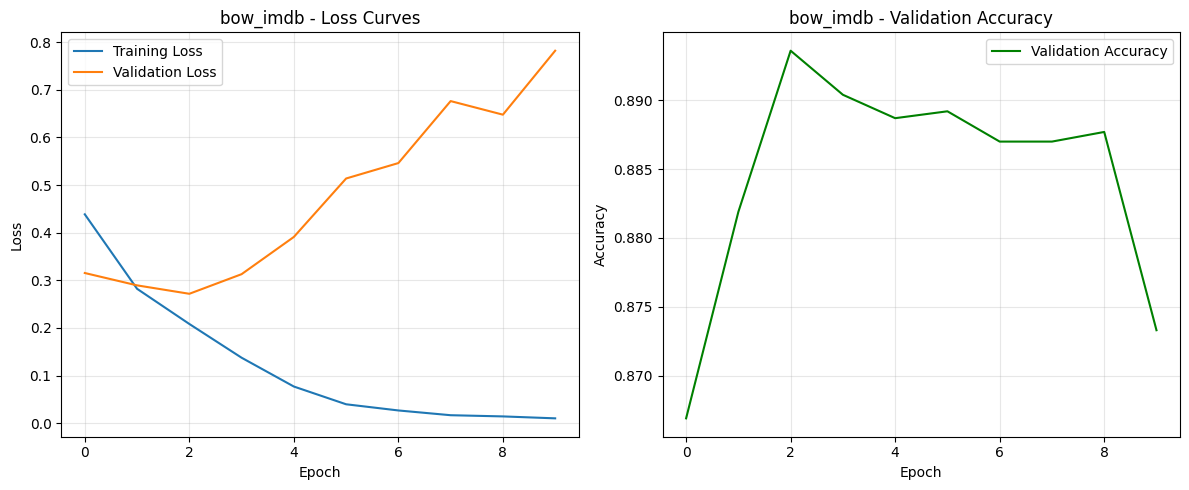


CONTINUING TRAINING OF BERT EMBEDDINGS MODEL ON IMDB DATASET
Loaded BERT Embeddings model checkpoint from checkpoints/bert_emb_sst2_best.pt
Checkpoint info - Epoch: 7, Val Acc: 0.8600


Epoch 1/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.43it/s]


Epoch 1/10
Train Loss: 0.6800, Val Loss: 0.5249, Val Acc: 0.7800
Checkpoint saved at checkpoints/bert_emb_imdb_best.pt with val_acc: 0.7800


Epoch 2/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.49it/s]


Epoch 2/10
Train Loss: 0.6434, Val Loss: 0.5172, Val Acc: 0.7800


Epoch 3/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.44it/s]


Epoch 3/10
Train Loss: 0.5969, Val Loss: 0.5057, Val Acc: 0.7750


Epoch 4/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.08it/s]


Epoch 4/10
Train Loss: 0.5354, Val Loss: 0.4989, Val Acc: 0.7700


Epoch 5/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.41it/s]


Epoch 5/10
Train Loss: 0.5509, Val Loss: 0.4967, Val Acc: 0.7550


Epoch 6/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 23.43it/s]


Epoch 6/10
Train Loss: 0.5057, Val Loss: 0.4969, Val Acc: 0.7800


Epoch 7/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.23it/s]


Epoch 7/10
Train Loss: 0.5505, Val Loss: 0.5057, Val Acc: 0.7800


Epoch 8/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.62it/s]


Epoch 8/10
Train Loss: 0.5419, Val Loss: 0.5031, Val Acc: 0.7800


Epoch 9/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.93it/s]


Epoch 9/10
Train Loss: 0.5359, Val Loss: 0.4972, Val Acc: 0.7750


Epoch 10/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 35.47it/s]


Epoch 10/10
Train Loss: 0.5286, Val Loss: 0.4954, Val Acc: 0.7750
Final model saved at checkpoints/bert_emb_imdb_final.pt


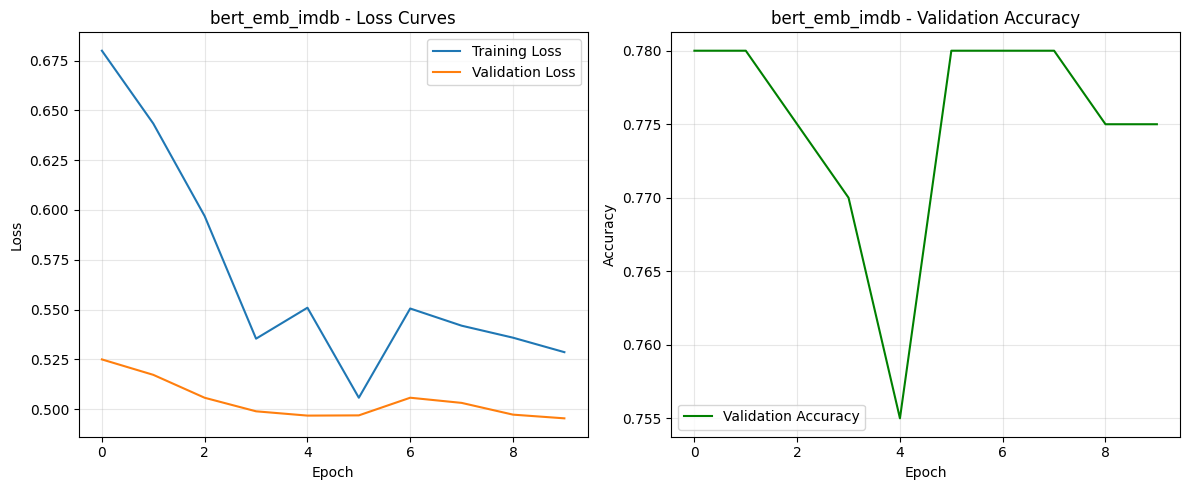


COMPARING MODELS ON IMDB DATASET
BoW Model Best Validation Accuracy: 0.8936
BERT Embeddings Model Best Validation Accuracy: 0.7800

FINAL COMPARISON ACROSS DATASETS
Bag-of-Words Model:
  SST2 Best Val Accuracy: 0.7863
  IMDB Best Val Accuracy: 0.8936

BERT Embeddings Model:
  SST2 Best Val Accuracy: 0.8600
  IMDB Best Val Accuracy: 0.7800


In [10]:

# TASK 6: Use checkpoints and train on Dataset 2 (IMDB)
# -----------------------------------------------------

# First, we need to prepare the IMDB dataset loaders
# For BoW approach:
imdb_train_data = pd.read_csv('imdb_train.csv')
imdb_val_data = pd.read_csv('imdb_val.csv')

# Extract BoW features
imdb_X_train_bow = vectorizer.transform(imdb_train_data['review'])
imdb_X_val_bow = vectorizer.transform(imdb_val_data['review'])

imdb_y_train = imdb_train_data['label'].values
imdb_y_val = imdb_val_data['label'].values

# Create BoW datasets and dataloaders for IMDB
imdb_bow_train_dataset = BowDataset(imdb_X_train_bow, imdb_y_train)
imdb_bow_val_dataset = BowDataset(imdb_X_val_bow, imdb_y_val)

imdb_bow_train_loader = DataLoader(imdb_bow_train_dataset, batch_size=64, shuffle=True)
imdb_bow_val_loader = DataLoader(imdb_bow_val_dataset, batch_size=64)

# For BERT embeddings approach:
# Process IMDB data for embeddings (using same sample size constraints)
print("Processing IMDB training data for embeddings...")
imdb_X_train_emb, imdb_y_train_emb = process_in_chunks(imdb_train_data,
                                                     chunk_size=50,
                                                     total_samples=200,
                                                     text_column='review')  # Specify the correct column name

print("Processing IMDB validation data for embeddings...")
imdb_X_val_emb, imdb_y_val_emb = process_in_chunks(imdb_val_data,
                                                 chunk_size=50,
                                                 total_samples=200,
                                                 text_column='review')  # Specify the correct column name

# Create embedding datasets and dataloaders for IMDB
imdb_emb_train_dataset = EmbeddingDataset(imdb_X_train_emb, imdb_y_train_emb)
imdb_emb_val_dataset = EmbeddingDataset(imdb_X_val_emb, imdb_y_val_emb)

imdb_emb_train_loader = DataLoader(imdb_emb_train_dataset, batch_size=32, shuffle=True)
imdb_emb_val_loader = DataLoader(imdb_emb_val_dataset, batch_size=32)

# 1. Continue training BoW model on IMDB
print("\n" + "="*50)
print("CONTINUING TRAINING OF BAG-OF-WORDS MODEL ON IMDB DATASET")
print("="*50)

# Initialize a new model
bow_model_imdb = SentimentMLP(input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2).to(device)

# Load the best checkpoint from SST2 training
bow_checkpoint_path = os.path.join("checkpoints", "bow_sst2_best.pt")
bow_checkpoint = torch.load(bow_checkpoint_path)
bow_model_imdb.load_state_dict(bow_checkpoint['model_state_dict'])
print(f"Loaded BoW model checkpoint from {bow_checkpoint_path}")
print(f"Checkpoint info - Epoch: {bow_checkpoint['epoch']}, Val Acc: {bow_checkpoint['val_acc']:.4f}")

# Initialize optimizer with smaller learning rate as specified
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model_imdb.parameters(), lr=0.0001)  # Smaller learning rate

# Continue training on IMDB dataset
bow_imdb_model, bow_imdb_train_losses, bow_imdb_val_losses, bow_imdb_val_accuracies, bow_imdb_best_val_acc = train_model(
    bow_model_imdb,
    imdb_bow_train_loader,
    imdb_bow_val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    model_name="bow_imdb"
)

# Plot training curves
plot_training_curves(bow_imdb_train_losses, bow_imdb_val_losses, bow_imdb_val_accuracies, model_name="bow_imdb")

# 2. Continue training BERT Embeddings model on IMDB
print("\n" + "="*50)
print("CONTINUING TRAINING OF BERT EMBEDDINGS MODEL ON IMDB DATASET")
print("="*50)

# Initialize a new model
emb_model_imdb = EmbeddingMLP(input_size=embedding_size, hidden_sizes=[512, 256, 128, 64], output_size=2).to(device)

# Load the best checkpoint from SST2 training
emb_checkpoint_path = os.path.join("checkpoints", "bert_emb_sst2_best.pt")
emb_checkpoint = torch.load(emb_checkpoint_path)
emb_model_imdb.load_state_dict(emb_checkpoint['model_state_dict'])
print(f"Loaded BERT Embeddings model checkpoint from {emb_checkpoint_path}")
print(f"Checkpoint info - Epoch: {emb_checkpoint['epoch']}, Val Acc: {emb_checkpoint['val_acc']:.4f}")

# Initialize optimizer with smaller learning rate as specified
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb_model_imdb.parameters(), lr=0.0001)  # Smaller learning rate

# Continue training on IMDB dataset
emb_imdb_model, emb_imdb_train_losses, emb_imdb_val_losses, emb_imdb_val_accuracies, emb_imdb_best_val_acc = train_model(
    emb_model_imdb,
    imdb_emb_train_loader,
    imdb_emb_val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    model_name="bert_emb_imdb"
)

# Plot training curves
plot_training_curves(emb_imdb_train_losses, emb_imdb_val_losses, emb_imdb_val_accuracies, model_name="bert_emb_imdb")

# Compare the two models on IMDB
print("\n" + "="*50)
print("COMPARING MODELS ON IMDB DATASET")
print("="*50)
print(f"BoW Model Best Validation Accuracy: {bow_imdb_best_val_acc:.4f}")
print(f"BERT Embeddings Model Best Validation Accuracy: {emb_imdb_best_val_acc:.4f}")

# Final comparison across datasets
print("\n" + "="*50)
print("FINAL COMPARISON ACROSS DATASETS")
print("="*50)
print("Bag-of-Words Model:")
print(f"  SST2 Best Val Accuracy: {bow_best_val_acc:.4f}")
print(f"  IMDB Best Val Accuracy: {bow_imdb_best_val_acc:.4f}")
print("\nBERT Embeddings Model:")
print(f"  SST2 Best Val Accuracy: {emb_best_val_acc:.4f}")
print(f"  IMDB Best Val Accuracy: {emb_imdb_best_val_acc:.4f}")